In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re
from scipy.stats import zscore
%matplotlib inline

In [2]:
data = pd.read_csv(r'C:\Users\Mikhail\Documents\Data 606\US_Accidents_Dec19_stage1.csv', parse_dates = ['Start_Time', 'End_Time', 'Time_Elapsed'], infer_datetime_format = True)

data.head()

,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Street,Side,...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Time_Elapsed
0,201,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,2,...,0,0,0,0,0,0,0,0,0,0 days 05:14:00.000000000
1,201,2,2016-02-08 06:07:00,2016-02-08 06:37:00,39.928059,-82.831184,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,1,...,0,0,0,0,0,0,0,0,1,0 days 00:30:00.000000000
2,201,2,2016-02-08 06:49:00,2016-02-08 07:19:00,39.063148,-84.032608,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,2,...,0,0,0,1,0,0,0,1,1,0 days 00:30:00.000000000
3,201,3,2016-02-08 07:23:00,2016-02-08 07:53:00,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,2,...,0,0,0,0,0,0,1,1,1,0 days 00:30:00.000000000
4,201,2,2016-02-08 07:39:00,2016-02-08 08:09:00,39.627781,-84.188354,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,2,...,0,0,0,1,0,1,1,1,1,0 days 00:30:00.000000000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 45 columns):
TMC                      1048575 non-null int64
Severity                 1048575 non-null int64
Start_Time               1048575 non-null datetime64[ns]
End_Time                 1048575 non-null datetime64[ns]
Start_Lat                1048575 non-null float64
Start_Lng                1048575 non-null float64
Distance(mi)             1048575 non-null float64
Description              1048575 non-null object
Street                   1048575 non-null object
Side                     1048575 non-null int64
City                     1048575 non-null object
County                   1048575 non-null object
State                    1048575 non-null object
Zipcode                  1048575 non-null object
Timezone                 1048575 non-null int64
Temperature(F)           1033294 non-null float64
Humidity(%)              1031978 non-null float64
Pressure(in)             1036396 non-

In [4]:
#More data cleaning. Sorting by date as well.
data = data.sort_values(by = ['Start_Time']).reset_index()
data.drop('index', axis = 1, inplace = True)
data.drop('Precipitation(in)', axis = 1, inplace = True)
data['Description'] = data['Description'].str.lower()
data['Highway'] = 0
data.loc[data['Description'].str.contains(r'accident on i-\d'), 'Highway'] = 1

In [5]:
#Making sure no one city has too high a percentage of missing values so that interpolation will not be accurate
null_cols = ['Temperature(F)', 'Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
null_percents = []
for n in null_cols:
    null_percents.append(data[data[n].isnull()]['City'].value_counts(normalize = True)[:10].values)

null_percents = [item for sublist in null_percents for item in sublist]
sorted(null_percents, reverse = True)

[0.12784300845718038,
 0.10176035599764413,
 0.09369163101765379,
 0.07955359885328146,
 0.07924644210095219,
 0.07722564322879373,
 0.05394531570736514,
 0.0514820592823713,
 0.046593809305673715,
 0.04380309694523107,
 0.041096786859498725,
 0.03789841537627282,
 0.03716596703184192,
 0.03481402413991296,
 0.034789250083536206,
 0.03235384457868332,
 0.02882237815647525,
 0.027485112230874943,
 0.02660316938993349,
 0.025305778152678194,
 0.023395105969079552,
 0.021705743831268557,
 0.021594547992446013,
 0.021202800863817813,
 0.02037473123784171,
 0.019521600289208893,
 0.01839231463995402,
 0.01721091551600026,
 0.017089121199102584,
 0.01658646462578069,
 0.01584623727179611,
 0.015574896930829134,
 0.015074705236526802,
 0.01494375564496264,
 0.01493150031027734,
 0.01433994095318431,
 0.014078017815091635,
 0.01346370431043309,
 0.012764332426368801,
 0.012231126107127795,
 0.011910215300045808,
 0.011659413744970851,
 0.011577305197471056,
 0.011160437252374814,
 0.0109658371

Max amount of missing values for any column for any city is 12%, which is very comfortably small enough for interpolation

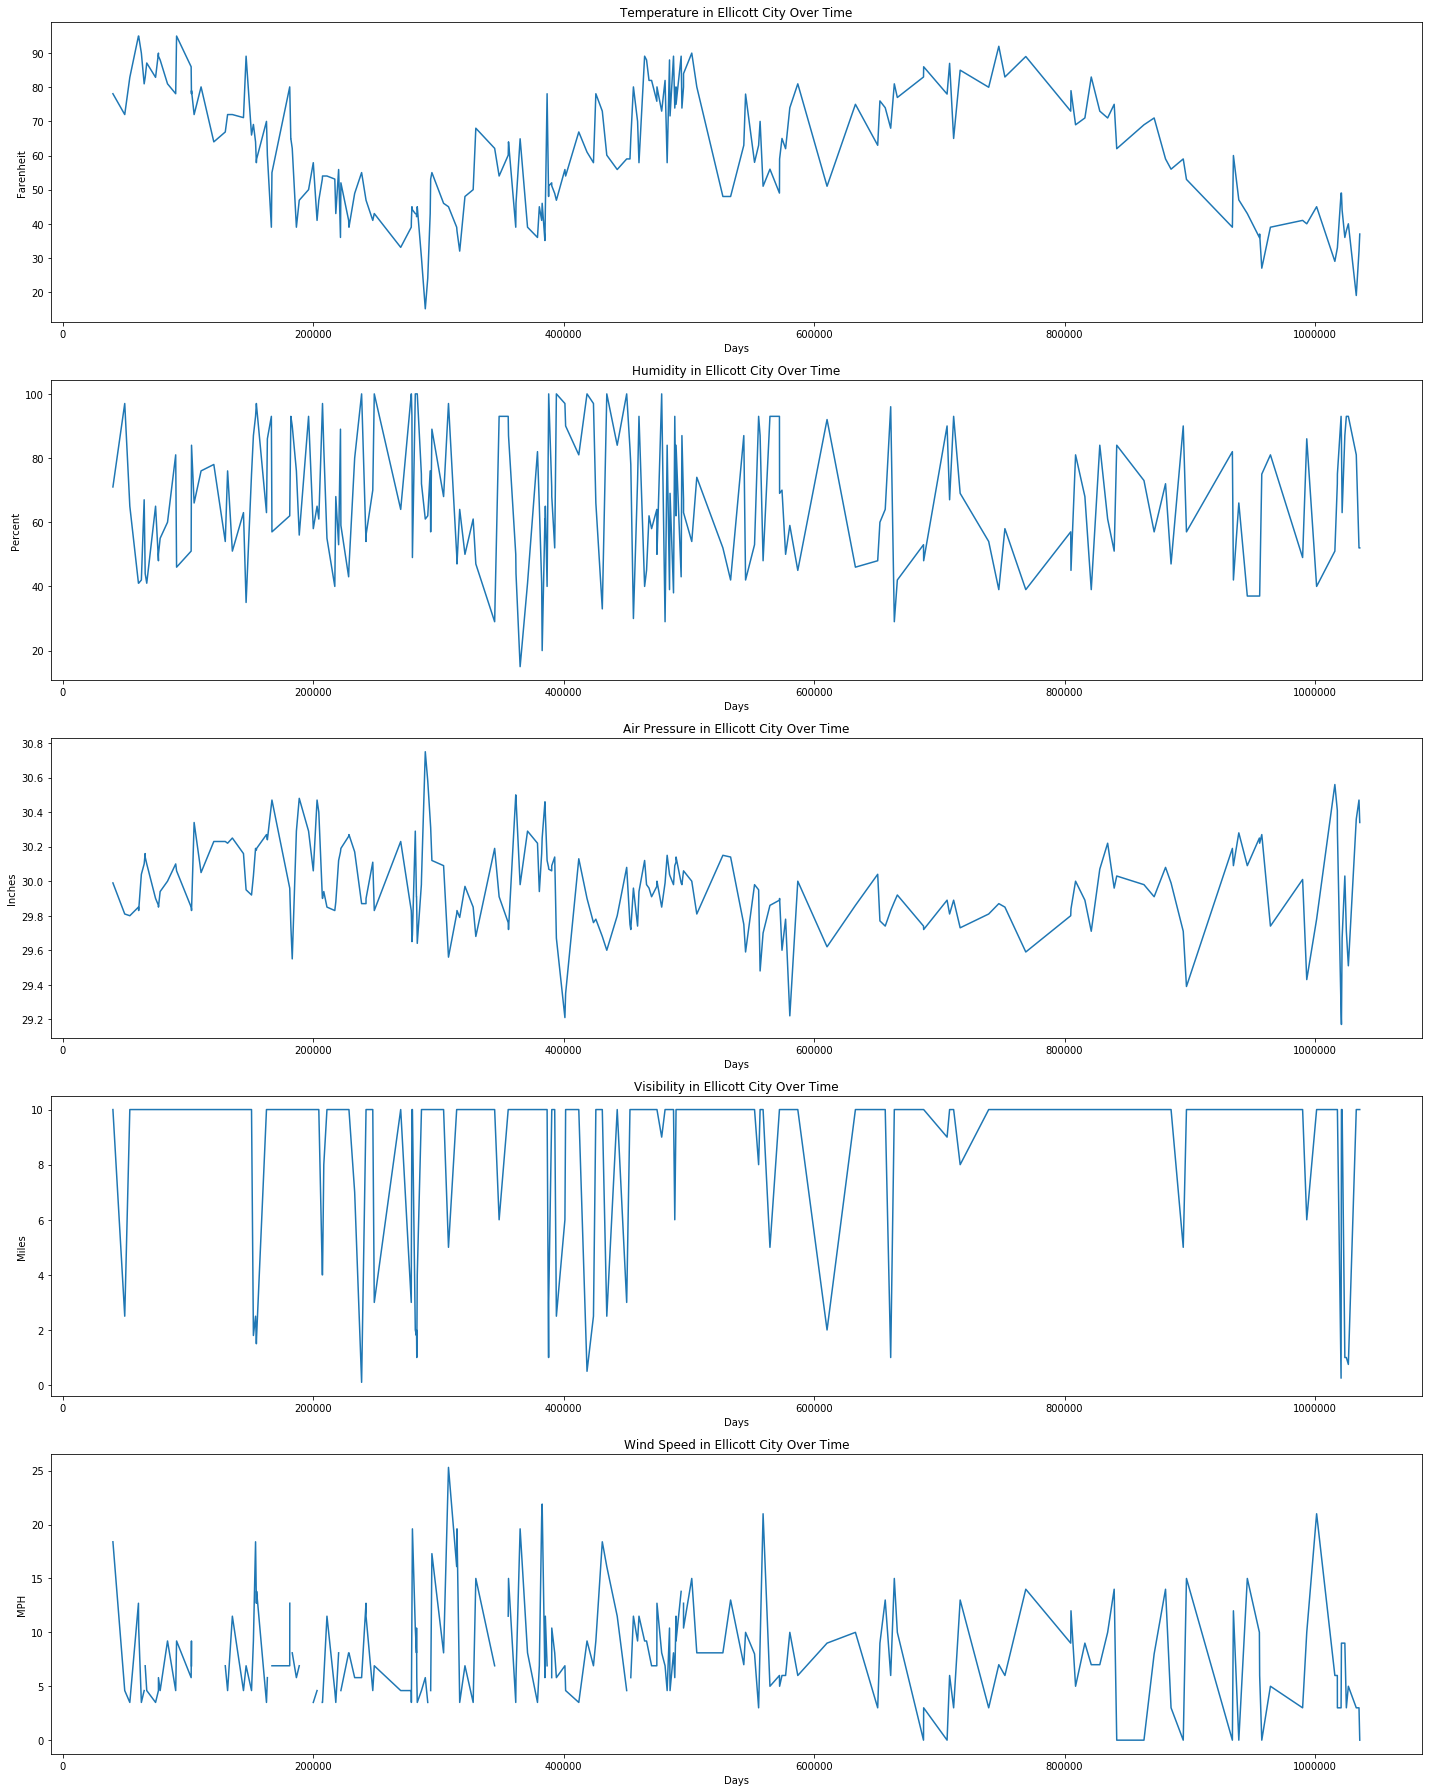

In [6]:
#Seeing the general pattern of columns with null values, using Ellicott City as an example.
null_cols = ['Temperature(F)', 'Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
num_cities = [len(data[data[n].isnull()]['City'].value_counts()) for n in null_cols]
nulls_per_city = [data[data[n].isnull()]['City'].value_counts().tolist() for n in null_cols]
city_names = [data[data[n].isnull()]['City'].value_counts().index for n in null_cols]

fig, axes = plt.subplots(5, figsize = (20,25))

axes[0].plot(data[(data['State'] == 'MD') & (data['City'] == 'Ellicott City')][null_cols[0]])
axes[0].set_title('Temperature in Ellicott City Over Time')
axes[0].set_ylabel('Farenheit')
axes[0].set_xlabel('Days')


axes[1].plot(data[(data['State'] == 'MD') & (data['City'] == 'Ellicott City')][null_cols[1]])
axes[1].set_title('Humidity in Ellicott City Over Time')
axes[1].set_ylabel('Percent')
axes[1].set_xlabel('Days')


axes[2].plot(data[(data['State'] == 'MD') & (data['City'] == 'Ellicott City')][null_cols[2]])
axes[2].set_title('Air Pressure in Ellicott City Over Time')
axes[2].set_ylabel('Inches')
axes[2].set_xlabel('Days')


axes[3].plot(data[(data['State'] == 'MD') & (data['City'] == 'Ellicott City')][null_cols[3]])
axes[3].set_title('Visibility in Ellicott City Over Time')
axes[3].set_ylabel('Miles')
axes[3].set_xlabel('Days')


axes[4].plot(data[(data['State'] == 'MD') & (data['City'] == 'Ellicott City')][null_cols[4]])
axes[4].set_title('Wind Speed in Ellicott City Over Time')
axes[4].set_ylabel('MPH')
axes[4].set_xlabel('Days')


plt.tight_layout()

I am deciding to group by each state and city, and linearly interpolate nulls from there

In [7]:
#Interpolation. Only filling in at most 4 nans at a time
def lin_interpolate(df):
   
    i_cols = ['Temperature(F)', 'Humidity(%)','Pressure(in)','Wind_Speed(mph)', 'Visibility(mi)']
    
    for i in i_cols:
        df[i] = df.groupby(['State', 'City'])[i].apply(lambda x: x.interpolate(limit = 4, limit_direction = 'both'))
    
    return df

data_filled = lin_interpolate(data.copy())
data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 45 columns):
TMC                      1048575 non-null int64
Severity                 1048575 non-null int64
Start_Time               1048575 non-null datetime64[ns]
End_Time                 1048575 non-null datetime64[ns]
Start_Lat                1048575 non-null float64
Start_Lng                1048575 non-null float64
Distance(mi)             1048575 non-null float64
Description              1048575 non-null object
Street                   1048575 non-null object
Side                     1048575 non-null int64
City                     1048575 non-null object
County                   1048575 non-null object
State                    1048575 non-null object
Zipcode                  1048575 non-null object
Timezone                 1048575 non-null int64
Temperature(F)           1043038 non-null float64
Humidity(%)              1042887 non-null float64
Pressure(in)             1043753 non-

In [8]:
data_filled.dropna(inplace = True)
print('Having interpolated as many missing values as possible and dropped remaining nulls, we have retained {}% of the data'.format(str(round(100*len(data_filled)/len(data),2))))

Having interpolated as many missing values as possible and dropped remaining nulls, we have retained 98.78% of the data


#  More EDA

In [9]:
data_filled['Day_of_Week'] = data_filled['Start_Time'].dt.weekday
data_filled['Hour'] = data_filled['Start_Time'].dt.hour
data_filled['Month'] = data_filled['Start_Time'].dt.month

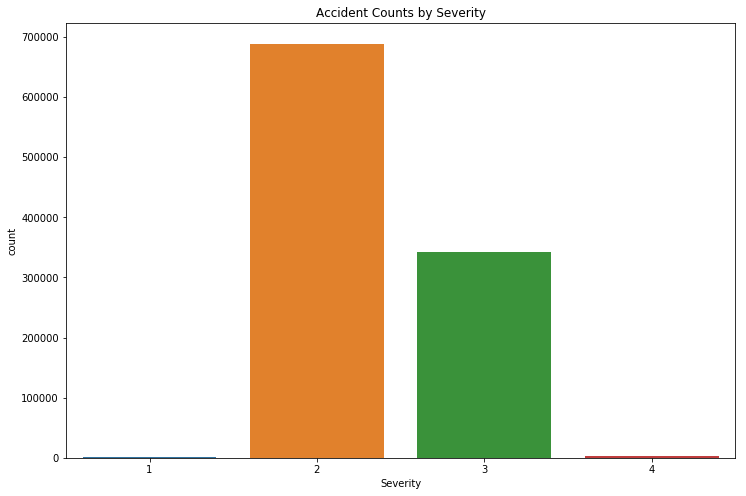

In [10]:
plt.figure(figsize = (12,8))
plt.title('Accident Counts by Severity')
sb.countplot('Severity',data=data_filled)
#Severity is highly bimodal

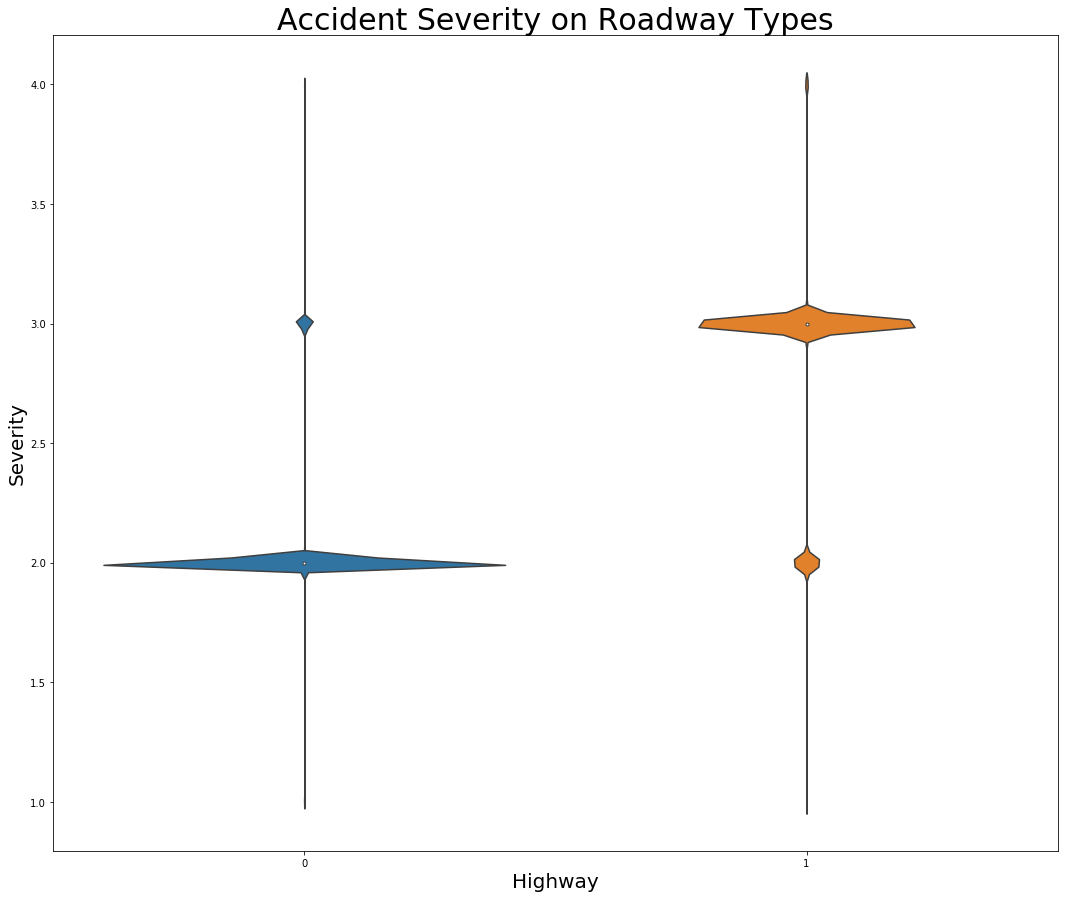

In [27]:
#More severe accidents on highways
sb.violinplot(x = 'Highway', y = 'Severity', data = data_filled)
plt.title('Accident Severity on Roadway Types', size = 30)
fig = plt.gcf()
fig.set_size_inches(18,15)
plt.xlabel('Highway', size = 20)
plt.ylabel('Severity', size = 20)
plt.savefig(r'C:\Users\Mikhail\Documents\Data 606\Delivery-2\road_types_accidents')

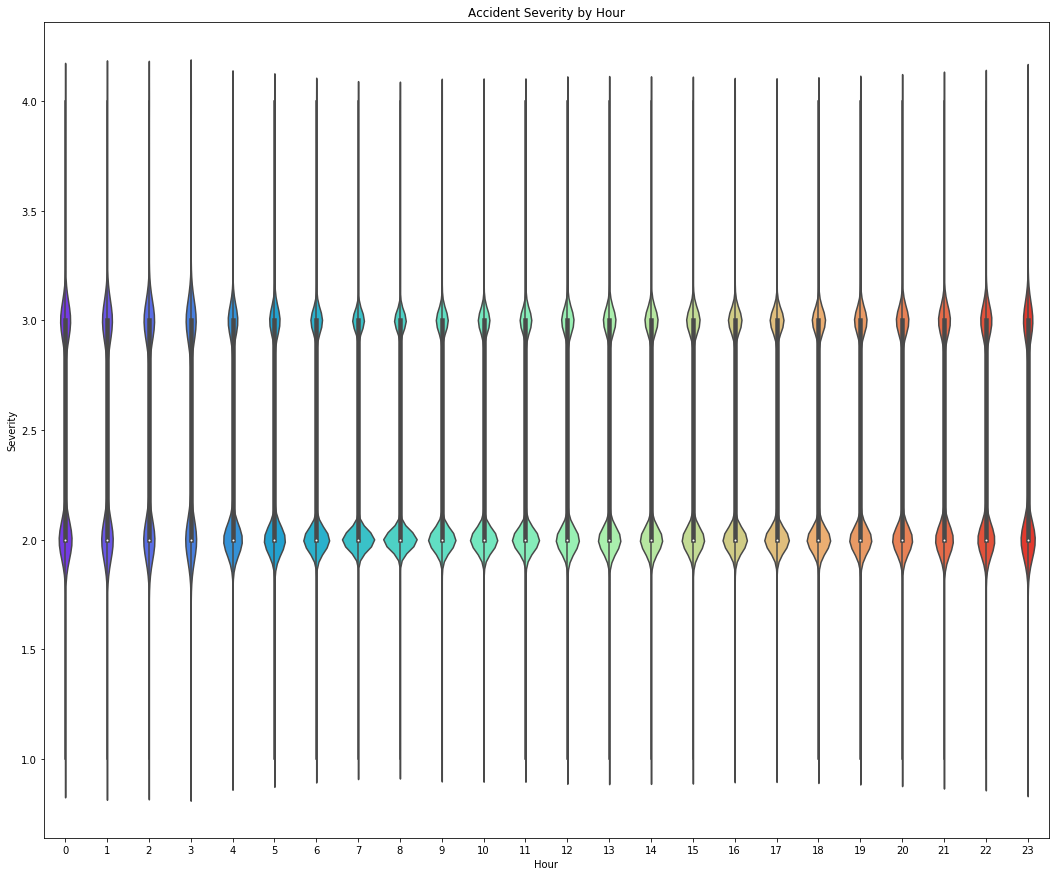

In [12]:
#Not much distinction by hour
sb.violinplot(x="Hour", y="Severity", data=data_filled,palette='rainbow')
plt.title('Accident Severity by Hour')
fig = plt.gcf()
fig.set_size_inches(18,15)

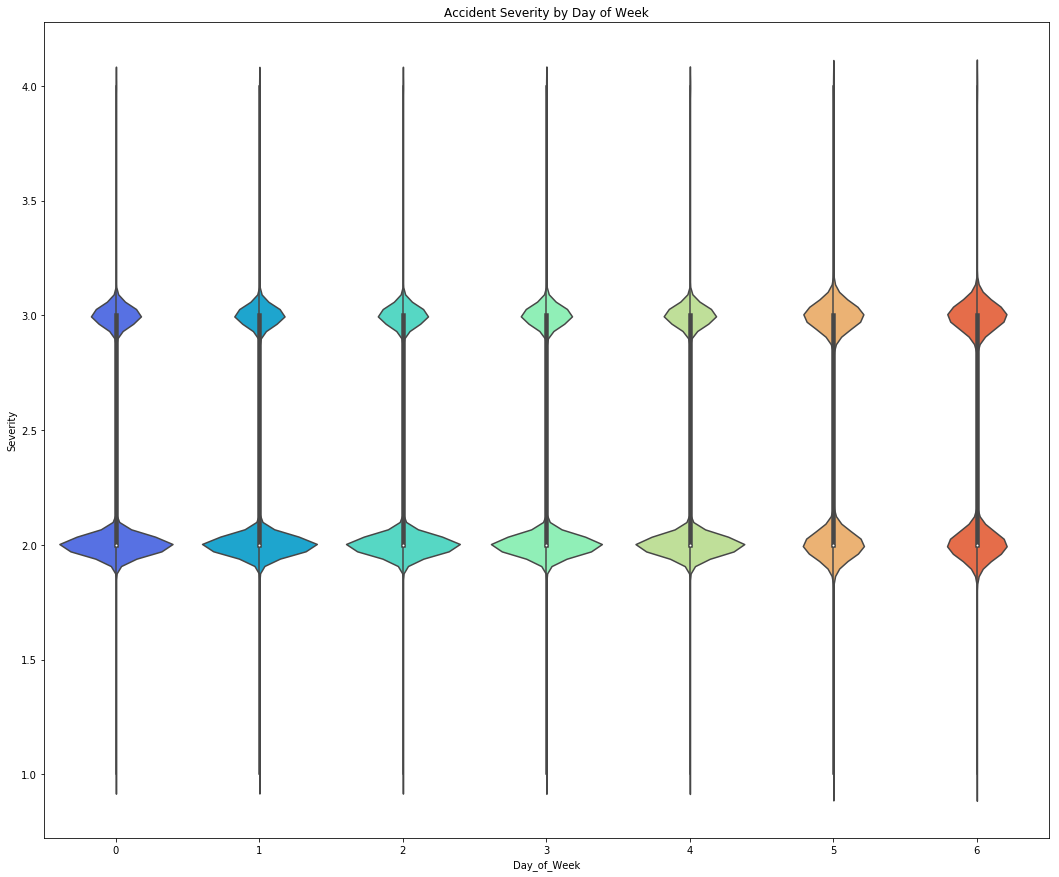

In [13]:
#Fewer accidents as a whole on Saturday and Sunday, and a higher proportion of 3's
sb.violinplot(x="Day_of_Week", y="Severity", data=data_filled,palette='rainbow')
plt.title('Accident Severity by Day of Week')
fig = plt.gcf()
fig.set_size_inches(18,15)

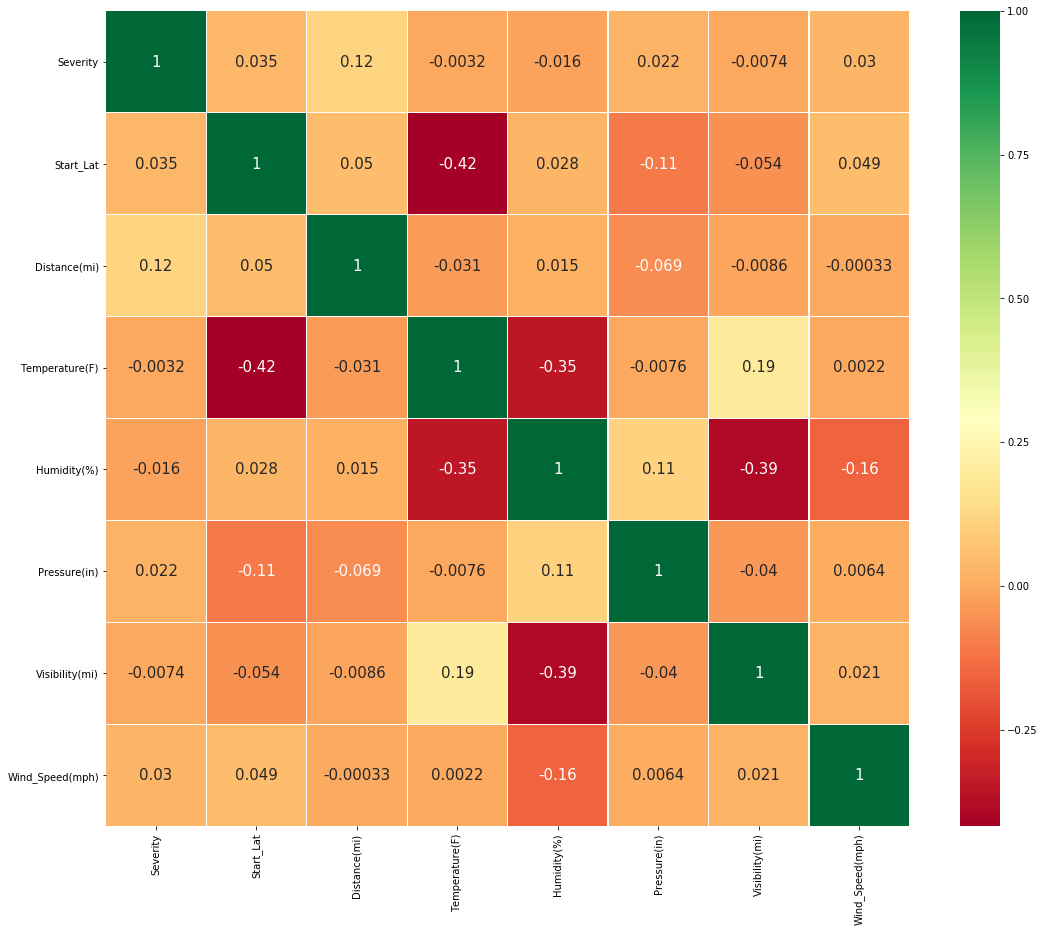

In [25]:
#Seeing if correlations exist
fig=sb.heatmap(data_filled[['Severity','Start_Lat','Distance(mi)','Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)']].corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':15})
fig = plt.gcf()
fig.set_size_inches(18,15)
plt.savefig(r'C:\Users\Mikhail\Documents\Data 606\Delivery-2\road_types_correlogram')

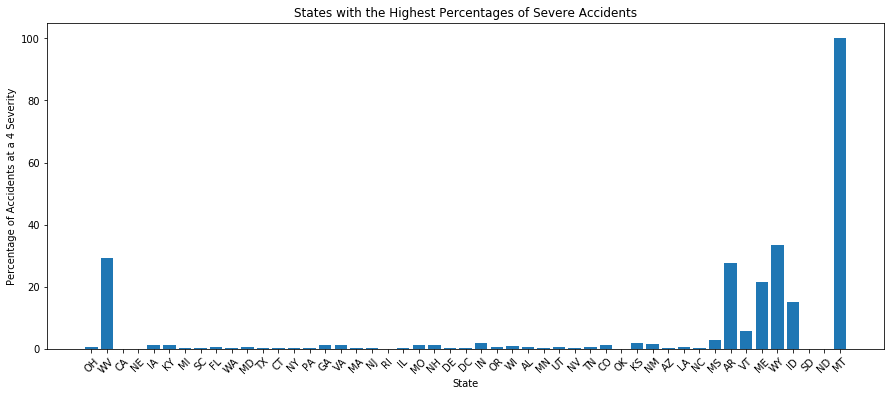

In [15]:
#Finding trends with the states of the most severe crashes
states = data_filled['State'].unique()
most_severe_by_state = [(len(data_filled[(data_filled['Severity'] == 4) & (data_filled['State'] == s)]) / len(data_filled[data_filled['State'] == s])) * 100 for s in states]
plt.bar(range(49), most_severe_by_state)
plt.xticks(range(49), states, rotation = 45)
plt.title('States with the Highest Percentages of Severe Accidents')
plt.ylabel('Percentage of Accidents at a 4 Severity')
plt.xlabel('State')
fig = plt.gcf()
fig.set_size_inches(15,6)
#WV, AR, ME, WY ID and MT have disproportionally high amounts of severe crashes

In [16]:
worst_states = ['WV', 'AR', 'ME', 'WY', 'ID', 'MT']
p_most_severe = pd.DataFrame(index = states, data = {'percent_by_state' : most_severe_by_state, 'z_score' : zscore(most_severe_by_state)})

print('Mean percentage of accidents that are very severe: {}\n'.format(round(np.mean(most_severe_by_state),2)))

for w in worst_states:
    print('Percentage of very severe accidents in {}: {}'.format(w, round(p_most_severe.loc[w, 'percent_by_state'],2)))
    print('This is {} standard deviations above the mean'.format(round(p_most_severe.loc[w, 'z_score'],2)))
    print('Number of observations for {}: {}\n'.format(w, str(len(data_filled[data_filled['State'] == w]))))

Mean percentage of accidents that are very severe: 5.28

Percentage of very severe accidents in WV: 29.41
This is 1.53 standard deviations above the mean
Number of observations for WV: 85

Percentage of very severe accidents in AR: 27.72
This is 1.43 standard deviations above the mean
Number of observations for AR: 101

Percentage of very severe accidents in ME: 21.43
This is 1.03 standard deviations above the mean
Number of observations for ME: 14

Percentage of very severe accidents in WY: 33.33
This is 1.78 standard deviations above the mean
Number of observations for WY: 12

Percentage of very severe accidents in ID: 15.0
This is 0.62 standard deviations above the mean
Number of observations for ID: 20

Percentage of very severe accidents in MT: 100.0
This is 6.02 standard deviations above the mean
Number of observations for MT: 1



West Virgina and Arkansas have a much higher percentage of severe accidents than the mean, with a satisfactorily large sample size. Montana is skewing the mean and standard error with its value of 100, and only has a sample size of 1. It needs to be dropped from the observations, and the figures recalculated.

In [17]:
p_most_severe = pd.DataFrame(index = states[:-1], data = {'percent_by_state' : most_severe_by_state[:-1], 'z_score' : zscore(most_severe_by_state[:-1])})

print('Mean percentage of accidents that are very severe: {}\n'.format(round(p_most_severe['percent_by_state'].mean(),2)))

for w in worst_states[:-1]:
    print('Percentage of very severe accidents in {}: {}'.format(w, round(p_most_severe.loc[w, 'percent_by_state'],2)))
    print('This is {} standard deviations above the mean'.format(round(p_most_severe.loc[w, 'z_score'],2)))
    print('Number of observations for {}: {}\n'.format(w, str(len(data_filled[data_filled['State'] == w]))))

Mean percentage of accidents that are very severe: 3.31

Percentage of very severe accidents in WV: 29.41
This is 3.32 standard deviations above the mean
Number of observations for WV: 85

Percentage of very severe accidents in AR: 27.72
This is 3.11 standard deviations above the mean
Number of observations for AR: 101

Percentage of very severe accidents in ME: 21.43
This is 2.3 standard deviations above the mean
Number of observations for ME: 14

Percentage of very severe accidents in WY: 33.33
This is 3.82 standard deviations above the mean
Number of observations for WY: 12

Percentage of very severe accidents in ID: 15.0
This is 1.49 standard deviations above the mean
Number of observations for ID: 20



Even without using a weighted mean, WV and AR display a statistically significantally higher percentage of very severe accidents and a high enough sample size that these results are credible. This merits further investigation.

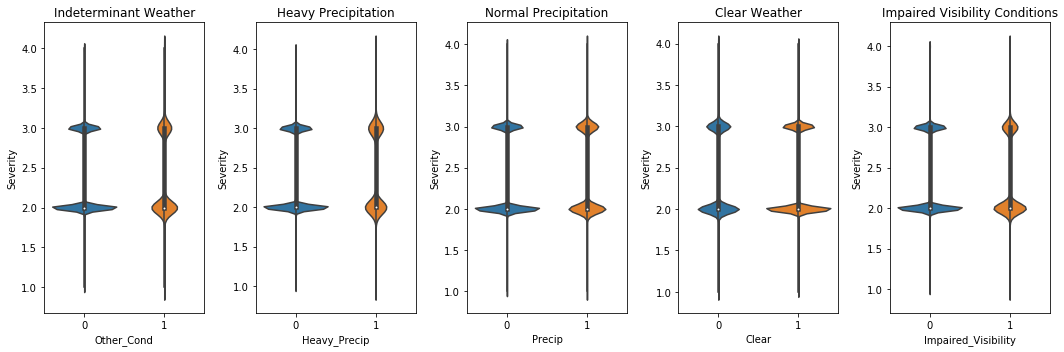

In [19]:
f, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (15,5))

weather_cols = data_filled.loc[:, 'Other_Cond' : 'Impaired_Visibility'].columns

sb.violinplot(ax = axs[0], data = data_filled, x = weather_cols[0], y = 'Severity')
axs[0].set_title('Indeterminant Weather')

sb.violinplot(ax = axs[1], data = data_filled, x = weather_cols[1], y = 'Severity')
axs[1].set_title('Heavy Precipitation')

sb.violinplot(ax = axs[2], data = data_filled, x = weather_cols[2], y = 'Severity')
axs[2].set_title('Normal Precipitation')

sb.violinplot(ax = axs[3], data = data_filled, x = weather_cols[3], y = 'Severity')
axs[3].set_title('Clear Weather')

sb.violinplot(ax = axs[4], data = data_filled, x = weather_cols[4], y = 'Severity')
axs[4].set_title('Impaired Visibility Conditions')

plt.tight_layout()
#Not much distinction by weather